# 43.1-modeling-ARIMA-Stationary-Test

> This notebook checks whether stationary applies to iPhone 11-13 data. The purpose of the notebook is to understand in what situations does stationarity exist, which means that the statistical properties of a process generating a time series do not change over time. If data is stationary, then it would be easier to analyze as this statistical consistency makes distributions predictable enabling forecasting.

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import numpy as np
from math import sqrt
import warnings

# Load the data

In [46]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

In [47]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


   weeks_monday  claim
0    2021-11-15      2
1    2021-11-22      3
2    2021-11-29      6
3    2021-12-06      2
4    2021-12-13     10
..          ...    ...
61   2023-01-16   3828
62   2023-01-23   4090
63   2023-01-30   3740
64   2023-02-06   4270
65   2023-02-13    847

[66 rows x 2 columns]
   weeks_monday  claim
0    2021-06-28   1499
1    2021-07-05   4068
2    2021-07-12   3753
3    2021-07-19   3664
4    2021-07-26   3583
..          ...    ...
81   2023-01-16   1856
82   2023-01-23   1751
83   2023-01-30   1536
84   2023-02-06   2157
85   2023-02-13    378

[86 rows x 2 columns]
   weeks_monday  claim
0    2021-06-28    422
1    2021-07-05   1017
2    2021-07-12   1045
3    2021-07-19   1144
4    2021-07-26   1157
..          ...    ...
81   2023-01-16   4277
82   2023-01-23   4136
83   2023-01-30   3764
84   2023-02-06   4604
85   2023-02-13    807

[86 rows x 2 columns]


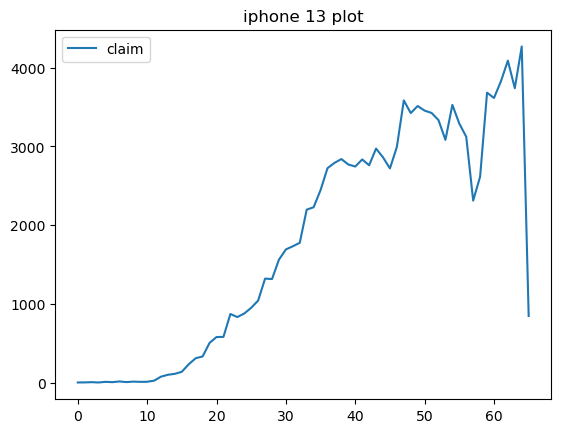

In [49]:
iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_13)
result_iphone_13.plot()
plt.title("iPhone 13 Plot")

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_11)

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_12)

,weeks_monday,claim
0,2021-11-15,2
1,2021-11-22,3
2,2021-11-29,6
3,2021-12-06,2
4,2021-12-13,10
...,...,...
60,2023-01-09,3616
61,2023-01-16,3828
62,2023-01-23,4090
63,2023-01-30,3740


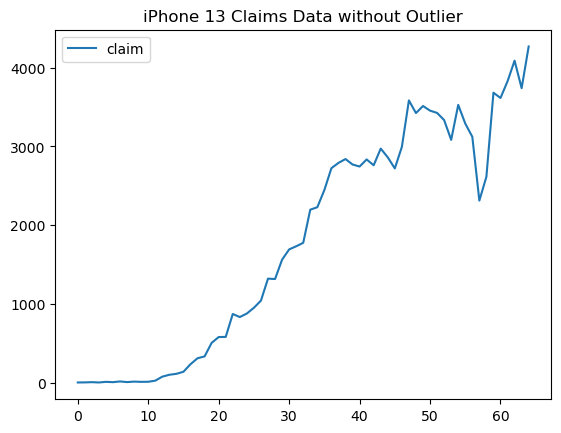

In [50]:
# Removing last data point as recommended by professor, we have reason to think that the data is an outlier due to
# the data being incomplete

result_iphone_13 = result_iphone_13[:65]

display(result_iphone_13)

result_iphone_13.plot()
plt.title("iPhone 13 Claims Data Without Outlier")

result_iphone_11 = result_iphone_11[:-1]
result_iphone_12 = result_iphone_12[:-1]

In [51]:
# Changed up result_iphone_11, result_iphone_11, result_iphone_13 so it can use the weeks_monday

result_iphone_13['weeks_monday'] = pd.to_datetime(result_iphone_13['weeks_monday'])
result_iphone_13.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_13 so it can use the weeks_monday

result_iphone_11['weeks_monday'] = pd.to_datetime(result_iphone_11['weeks_monday'])
result_iphone_11.set_index('weeks_monday', inplace = True)

result_iphone_12['weeks_monday'] = pd.to_datetime(result_iphone_12['weeks_monday'])
result_iphone_12.set_index('weeks_monday', inplace = True)

In [52]:
# Creating a copy version to conduct the stationary tests
result_iphone_13_v1 = result_iphone_13.copy()

display(result_iphone_13.head())
result_iphone_13.info()

result_iphone_11_v1 = result_iphone_11.copy()

display(result_iphone_11.head())
result_iphone_11.info()

result_iphone_12_v1 = result_iphone_12.copy()

display(result_iphone_12.head())
result_iphone_12.info()

,claim
weeks_monday,
2021-11-15,2
2021-11-22,3
2021-11-29,6
2021-12-06,2
2021-12-13,10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2021-11-15 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   65 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


,claim
weeks_monday,
2021-06-28,1499
2021-07-05,4068
2021-07-12,3753
2021-07-19,3664
2021-07-26,3583


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2021-06-28 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   85 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


,claim
weeks_monday,
2021-06-28,422
2021-07-05,1017
2021-07-12,1045
2021-07-19,1144
2021-07-26,1157


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2021-06-28 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   85 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


Text(0.5, 1.0, 'iPhone 13 Claims Data')

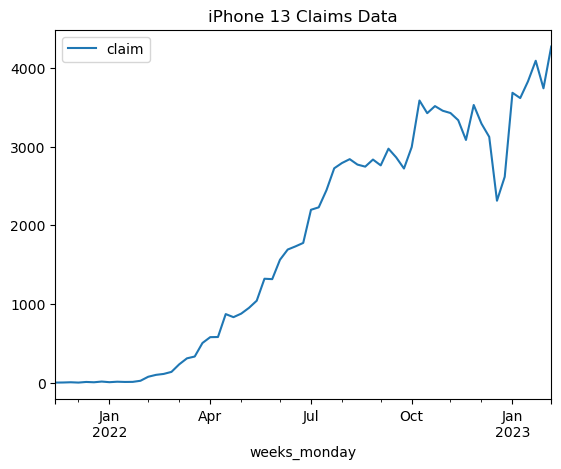

In [18]:
result_iphone_13.plot()
plt.title("iPhone 13 Claims Data")
# Checking with the iPhone 13 data if the weeks_monday was converted properly
# Plot has x-axis as weeks_monday

# Stationary Test

## iPhone 13

### iPhone 13 - Stationary Method #1 - Stepwise Implementation

##### We see that iPhone 13 is not stationary in this method, so we try the ADF method

In [39]:
values = result_iphone_13_v1.values
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

# We see that it's not stationary in this test, we will move on to seeing the log version

mean1=118.904762, mean2=1815.857143, mean3=3248.619048
variance1=28759.419501, variance2=597250.693878, variance3=184272.997732


In [38]:
# Checking if stationary applies when using log values to normalize iPhone 13 through stepwise implementation

values = np.log(result_iphone_13_v1.values)
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

mean1=3.413182, mean2=7.396926, mean3=8.076850
variance1=3.356000, variance2=0.235996, variance3=0.018746


### iPhone 13 - Stationary Method #2 - Augmented Dickey-Fuller Test

##### We see that the iPhone 13 is stationary when we normalize the iPhone 13 data with log

In [42]:
# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

values = result_iphone_13_v1.values
 
# passing the extracted value count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))


# p-value is 0.945841, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -0.134980
p-value: 0.945841
critical values at different levels:
	1%: -3.537
	5%: -2.908
	10%: -2.591


In [44]:
# Normalizing the iPhone 13 log function to see if ADF shows there is stationary data

# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

# values function and applying log transform on it.
values = np.log(result_iphone_13_v1.values)
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
    

# The p-value = 0, which means that the iPhone 13 data is stationary when we apply log to normalize it

Augmneted Dickey_fuller Statistic: -8.396755
p-value: 0.000000
critical values at different levels:
	1%: -3.555
	5%: -2.916
	10%: -2.596


## iPhone 11

### iPhone 11 - Stationary Method #1 - Stepwise Implementation

In [55]:
values = result_iphone_11_v1.values
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

# The mean values and variance is too different, so we see that it's not stationary

mean1=3338.357143, mean2=2416.357143, mean3=2327.321429
variance1=205211.729592, variance2=44723.872449, variance3=114894.932398


In [56]:
# Checking if stationary applies to iPhone 11 values after normalizing the data through log values

values = np.log(result_iphone_11_v1.values)
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

# The mean values are relatively similar and the variances are small, so there is potential reason to believe that the
# iphone 11 data is stationary

mean1=8.100642, mean2=7.786110, mean3=7.741152
variance1=0.029997, variance2=0.007906, variance3=0.023487


### iPhone 11 - Stationary Method #2 - Augmented Dickey-Fuller Test

##### We see that the data is not stationary for iPhone 11 under the ADF test

In [53]:
# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

values = result_iphone_11_v1.values
 
# passing the extracted value count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))


# p-value is 0.306821, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -1.954614
p-value: 0.306821
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586


In [54]:
# Applying log function on iphone 11 data to see if ADF shows there is stationary data

# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

# values function and applying log transform on it.
values = np.log(result_iphone_11_v1.values)
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
    
# p-value is 0.325141, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -1.914779
p-value: 0.325141
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586


## iPhone 12

### iPhone 12 - Stationary Method #1 - Stepwise Implementation

##### We see that iPhone 12 is not stationary in this method, so we try the ADF method

In [60]:
values = result_iphone_12_v1.values
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

# We see that it's not stationary

mean1=1681.035714, mean2=2665.035714, mean3=4114.821429
variance1=233380.177296, variance2=259333.034439, variance3=94236.360969


In [61]:
# Checking if stationary applies when using log values

values = np.log(result_iphone_11_v1.values)
 
# getting the count to split the dataset into 3 parts
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f' % (var_1, var_2, var_3))

mean1=8.100642, mean2=7.786110, mean3=7.741152
variance1=0.029997, variance2=0.007906, variance3=0.023487


### iPhone 12 - Stationary Method #2 - Augmented Dickey-Fuller Test

##### We see that the data is not stationary for iPhone 12 under the ADF test

In [57]:
# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

values = result_iphone_12_v1.values
 
# passing the extracted value count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))


# p-value is 0.609590, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -1.342332
p-value: 0.609590
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586


In [62]:
# Applying log function on iphone 11 data to see if ADF shows there is stationary data

# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

# values function and applying log transform on it.
values = np.log(result_iphone_12_v1.values)
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
    
# p-value is 0.195579, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -2.229883
p-value: 0.195579
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586
